In [1]:
# import libraries 

import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

from utils.config import EXPERIMENTAL_FOLDER, SIMULATED_FOLDER
from utils.preprocess import preprocess_simulation_output_data, preprocess_experimental_backgroundwhite_rawfiles

In [31]:
""" Raw experimental images"""

filepath_exp= EXPERIMENTAL_FOLDER
filename_exp= 'Fixed_19_1.TIF'


"""" Simulation image for the corresponding experimental image """

# Define the folder where the images are stored
filepath_sim = SIMULATED_FOLDER
filename_sim='Fixed_19_1.TIF'


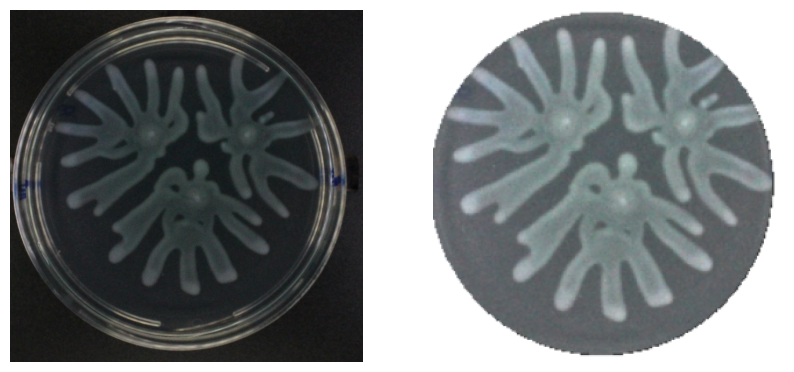

In [32]:
# Plot original raw image and preprocessed image side by side

img_exp_raw= cv2.imread(os.path.join(filepath_exp, filename_exp))
img_exp_rgb= cv2.cvtColor(img_exp_raw, cv2.COLOR_BGR2RGB)
img_exp_processed = preprocess_experimental_backgroundwhite_rawfiles(filepath_exp,0,1,img_filenames=[filename_exp])

# Handle the processed image - convert to numpy array and squeeze if needed
img_exp_processed = np.array(img_exp_processed)
if len(img_exp_processed.shape) == 4 and img_exp_processed.shape[0] == 1:
    img_exp_processed = img_exp_processed.squeeze(0)  # Remove batch dimension if present
if len(img_exp_processed.shape) == 3:
    img_exp_processed = img_exp_processed.squeeze()  # Remove single channel dimension if present

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)

plt.imshow(img_exp_rgb, cmap='gray')
plt.axis('off')         
plt.subplot(1,2,2)

plt.imshow(img_exp_processed, cmap='gray')
plt.axis('off')
plt.show()

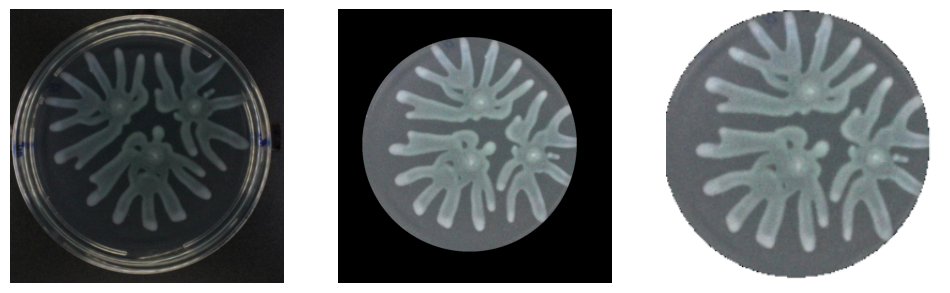

In [33]:
"""Rotation augmentation example, in total experiments include rotations per 3.6 degrees i.e 100 rotations per image """

# resizing params
top_crop=25
bottom_crop=25
left_crop=25        
right_crop=25

img_length =256 
img_width = 256


img = cv2.imread(os.path.join(filepath_exp,filename_exp))
img_rgb=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Convert the image to grayscale
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Find edges in the image using Canny edge detection
edges = cv2.Canny(img_gray, 100, 200)

# Find circles in the image using HoughCircles method
circles = cv2.HoughCircles(edges, cv2.HOUGH_GRADIENT, dp=1, minDist=20,
                           param1=50, param2=30, minRadius=20, maxRadius=600)

# print(circles)

# Assuming the first detected circle is the plate (adjust accordingly)
if circles is not None:
    circles = np.round(circles[0, :]).astype("int")
    for (x_center, y_center, radius) in circles:
        # Define a new radius for the mask that is 20 pixels smaller than the detected radius
        new_radius = radius -82
        # print(new_radius)

        # Create a mask where all values are set to zero (black)
        mask = np.zeros((img.shape[0], img.shape[1]), dtype=np.uint8)

        # Draw a filled white circle on the mask where the new, smaller circle is
        cv2.circle(mask, (x_center, y_center), new_radius, (255, 255, 255), -1)

        # Apply the mask to the original image (set pixels outside the new circle to black)
        img_masked = cv2.bitwise_and(img, img, mask=mask)


        # Adjust contrast and brightness
        alpha = 1.5  # Contrast control (1.0-3.0)
        beta = 50    # Brightness control (0-100)
        adjusted_image = cv2.convertScaleAbs(img_masked, alpha=alpha, beta=beta)

        # Specify the rotation angle theta in degrees
        theta = 45 #45
        theta_rad = np.deg2rad(theta)

        # Create an output image (initially black or any background color you prefer)
        output_img = np.zeros_like(img)

        # Iterate over each pixel in the output image
        for x_prime in range(img.shape[1]):
            for y_prime in range(img.shape[0]):
                # Apply the inverse rotation transformation (backward mapping)
                x = np.cos(theta_rad) * (x_prime - x_center) + np.sin(theta_rad) * (y_prime - y_center) + x_center
                y = -np.sin(theta_rad) * (x_prime - x_center) + np.cos(theta_rad) * (y_prime - y_center) + y_center

                # Check if the source pixel (x, y) is within the new circle's boundaries
                if (x - x_center)**2 + (y - y_center)**2 <= new_radius**2:
                    # Check if it's inside the image
                    if 0 <= x < img.shape[1] and 0 <= y < img.shape[0]:
                        # Sample the pixel from the masked image to the output image
                        output_img[y_prime, x_prime] = adjusted_image[int(y), int(x)]

        # Convert BGR images to RGB for plotting with matplotlib
        img_masked_rgb = cv2.cvtColor(img_masked, cv2.COLOR_BGR2RGB)
        output_img_rgb = cv2.cvtColor(output_img, cv2.COLOR_BGR2RGB)

       

        # convert to white background, this part is similar to the function preprocess_experimental_backgroundwhite
      

        output_img_resized = cv2.resize(output_img_rgb, (img_width, img_length))

        # do some cropping
        new_height = output_img_resized.shape[0] - (top_crop + bottom_crop)
        new_width = output_img_resized.shape[1] - (left_crop + right_crop)

        output_img_resized = output_img_resized[top_crop:top_crop+new_height, left_crop:left_crop+new_width]

        # now change black to white for the masked area
        output_img_resized[np.all(output_img_resized == [0,0,0], axis=-1)] = [255,255,255]  # change black to white

        # resize after cropping
        output_img_resized = cv2.resize(output_img_resized, (img_width, img_length))




        # Plot the masked original image
        plt.figure(figsize=(12, 6))
        plt.subplot(1, 3, 1)
        plt.imshow(img_rgb)
        # plt.title('Masked Original Image')
        plt.axis("off")

        # Plot the image after rotation within the masked circle
        plt.subplot(1, 3, 2)
        plt.imshow(output_img_rgb)
        plt.axis("off")
        # plt.title('Image after rotation within the masked circle(croppping plus thresholding)')
        
        plt.subplot(1,3,3)
        plt.imshow(output_img_resized)
        plt.axis("off")

        break
else:
    print("No circles were found")


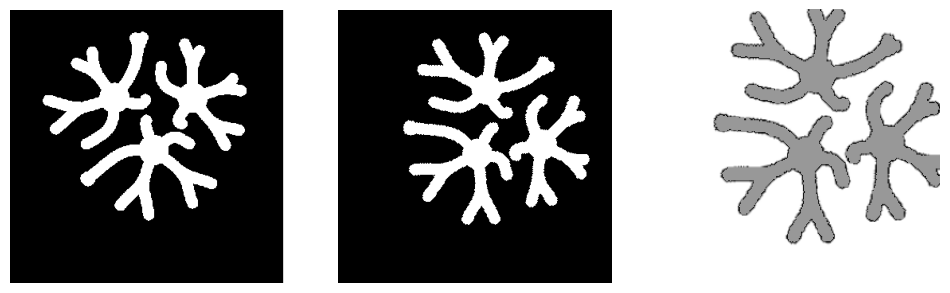

In [34]:

"""Rotation augmentation example, similar as experiments each image rotated per 3.6 degrees i.e 100 rotations per image """
# Define the rotation angle theta in degrees
theta = 45  # Replace with your desired rotation angle
theta_rad = np.deg2rad(theta)

# resizing params
top_crop=25
bottom_crop=25
left_crop=25        
right_crop=25

img_length =256 
img_width = 256

# List all image files in the folder
# image_files = [f for f in os.listdir(folder_path) if f.endswith(('.png', '.jpg', '.jpeg'))]

# Process each image file
# for image_file in image_files:
# Read the image
img = cv2.imread(os.path.join(filepath_sim, filename_sim))

# Find the center of the image (which is also the center of the inscribed circle)
center_x, center_y = img.shape[1] // 2, img.shape[0] // 2

# Radius of the inscribed circle is half the length of the shortest side of the rectangle
radius = min(center_x, center_y)

# Create an output image (initially black or any background color you prefer)
output_img = np.zeros_like(img)

# Perform backward mapping rotation for points within the inscribed circle
for x_prime in range(img.shape[1]):
    for y_prime in range(img.shape[0]):
        # Apply the inverse rotation transformation (backward mapping)
        x = np.cos(theta_rad) * (x_prime - center_x) + np.sin(theta_rad) * (y_prime - center_y) + center_x
        y = -np.sin(theta_rad) * (x_prime - center_x) + np.cos(theta_rad) * (y_prime - center_y) + center_y

        # Check if the source pixel (x, y) is within the inscribed circle's boundaries
        if (x - center_x)**2 + (y - center_y)**2 <= radius**2:
            # Check if it's inside the image
            if 0 <= x < img.shape[1] and 0 <= y < img.shape[0]:
                # Sample the pixel from the original image to the output image
                output_img[y_prime, x_prime] = img[int(y), int(x)]


# Convert BGR images to RGB for plotting with matplotlib
output_img_rgb = cv2.cvtColor(output_img, cv2.COLOR_BGR2RGB)



# Using gray color for final network training, this part is similar to the function preprocess_simulation_output_data
# resize the image
img_array_o=cv2.resize(output_img_rgb, (img_width, img_length))
new_height = img_array_o.shape[0] - (top_crop + bottom_crop)
new_width = img_array_o.shape[1] - (left_crop + right_crop)

new_array_o = img_array_o[top_crop:top_crop + new_height, left_crop:left_crop + new_width]

new_array_o = cv2.resize(new_array_o, (img_length, img_width))

# Convert images to gray on light background for better visualization
img_inverse = cv2.bitwise_not(np.array(new_array_o))

#  Change artificial color to gray for visualization
#  Extra thresholding step for predicted images to remove noise
img_inverse=cv2.threshold(img_inverse, 10, 255, cv2.THRESH_TOZERO)[1]
#  Change black to gray (for grayscale images)
img_inverse[img_inverse == 0] = 152



# Display the output image
plt.figure(figsize=(12, 6))
plt.subplot(1,3,1)
plt.imshow(img)
plt.axis('off')
# plt.title('Original image')


plt.subplot(1,3,2)
plt.imshow(output_img_rgb)
plt.axis('off')
# plt.title(f'Rotated Image within Inscribe Circle ')




plt.subplot(1,3,3)
plt.imshow(img_inverse)
plt.axis('off')
# plt.title(f'Rotated Image within Inscribe Circle ')
plt.show()

In [ ]:
"""Describes how the experimental and simulation images were augmented
Note here we just describe how to rotate by a random angle, but in reality we rotate by 100 different angles per image.
Similar to the Seed_DataAugmentation.py file, just example do not run this block here"""

import cv2
import numpy as np
import os
import random
import matplotlib.pyplot as plt

# def rotate_image(img, angle, center=None, scale=1.0):
#     (h, w) = img.shape[:2]
#     if center is None:
#         center = (w // 2, h // 2)
#     M = cv2.getRotationMatrix2D(center, angle, scale)
#     rotated = cv2.warpAffine(img, M, (w, h))
#     return rotated

def crop_and_rotate_experimental(img, angle):

    # img = cv2.imread(img)

    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find edges in the image using Canny edge detection
    edges = cv2.Canny(img_gray, 100, 200)

    # Find circles in the image using HoughCircles method
    circles = cv2.HoughCircles(edges, cv2.HOUGH_GRADIENT, dp=1, minDist=20,
                            param1=50, param2=30, minRadius=20, maxRadius=600)
    
    # print(circles)

    # Assuming the first detected circle is the plate (adjust accordingly)
    if circles is not None:
        circles = np.round(circles[0, :]).astype("int")
        for (x_center, y_center, radius) in circles:
            # Define a new radius for the mask that is 20 pixels smaller than the detected radius
            new_radius = radius -82
            # print(new_radius)

            # Create a mask where all values are set to zero (black)
            mask = np.zeros((img.shape[0], img.shape[1]), dtype=np.uint8)

            # Draw a filled white circle on the mask where the new, smaller circle is
            cv2.circle(mask, (x_center, y_center), new_radius, (255, 255, 255), -1)

            # Apply the mask to the original image (set pixels outside the new circle to black)
            img_masked = cv2.bitwise_and(img, img, mask=mask)
            
            # Adjust contrast and brightness
            alpha = 1.5  # Contrast control (1.0-3.0)
            beta = 50    # Brightness control (0-100)
            adjusted_image = cv2.convertScaleAbs(img_masked, alpha=alpha, beta=beta)

            angle=np.linspace(0,360-3.6,100)
            for i in range(0,len(angle)):
            # Specify the rotation angle theta in degrees
                theta = angle[i]
                theta_rad = np.deg2rad(theta)

                # Create an output image (initially black or any background color you prefer)
                output_img = np.zeros_like(img)

                # Iterate over each pixel in the output image
                for x_prime in range(img.shape[1]):
                    for y_prime in range(img.shape[0]):
                        # Apply the inverse rotation transformation (backward mapping)
                        x = np.cos(theta_rad) * (x_prime - x_center) + np.sin(theta_rad) * (y_prime - y_center) + x_center
                        y = -np.sin(theta_rad) * (x_prime - x_center) + np.cos(theta_rad) * (y_prime - y_center) + y_center

                        # Check if the source pixel (x, y) is within the new circle's boundaries
                        if (x - x_center)**2 + (y - y_center)**2 <= new_radius**2:
                            # Check if it's inside the image
                            if 0 <= x < img.shape[1] and 0 <= y < img.shape[0]:
                                # Sample the pixel from the masked image to the output image
                                output_img[y_prime, x_prime] = adjusted_image[int(y), int(x)]

            # # Convert BGR images to RGB for plotting with matplotlib
            # img_masked_rgb = cv2.cvtColor(img_masked, cv2.COLOR_BGR2RGB)
            # output_img_rgb = cv2.cvtColor(output_img, cv2.COLOR_BGR2RGB)

    #         # Plot the masked original image
    #         plt.figure(figsize=(12, 6))
    #         plt.subplot(1, 2, 1)
    #         plt.imshow(img_masked_rgb)
    #         plt.title('Masked Original Image')

    #         # Plot the image after rotation within the masked circle
    #         plt.subplot(1, 2, 2)
    #         plt.imshow(output_img_rgb)
    #         plt.title('Image after rotation within the masked circle')
    #         plt.show()
                break  # needed since assuming first circle detected by Hough transform is the plate
        
    else:
        print("No circles were found")

    return output_img,adjusted_image
 

def process_simulation_image(img, angle):
    # Find the center of the image (which is also the center of the inscribed circle)

    # img=cv2.imread(img)

    theta = angle # Replace with your desired rotation angle
    theta_rad = np.deg2rad(theta)

    # List all image files in the folder
    # image_files = [f for f in os.listdir(folder_path) if f.endswith(('.png', '.jpg', '.jpeg'))]

    # Process each image file
    # for image_file in image_files:
        # Read the image
    # img = cv2.imread(os.path.join(folder_path, filepath))

    # Find the center of the image (which is also the center of the inscribed circle)
    center_x, center_y = img.shape[1] // 2, img.shape[0] // 2

    # Radius of the inscribed circle is half the length of the shortest side of the rectangle
    radius = min(center_x, center_y)

    # Create an output image (initially black or any background color you prefer)
    output_img = np.zeros_like(img)

    # Perform backward mapping rotation for points within the inscribed circle
    for x_prime in range(img.shape[1]):
        for y_prime in range(img.shape[0]):
            # Apply the inverse rotation transformation (backward mapping)
            x = np.cos(theta_rad) * (x_prime - center_x) + np.sin(theta_rad) * (y_prime - center_y) + center_x
            y = -np.sin(theta_rad) * (x_prime - center_x) + np.cos(theta_rad) * (y_prime - center_y) + center_y

            # Check if the source pixel (x, y) is within the inscribed circle's boundaries
            if (x - center_x)**2 + (y - center_y)**2 <= radius**2:
                # Check if it's inside the image
                if 0 <= x < img.shape[1] and 0 <= y < img.shape[0]:
                    # Sample the pixel from the original image to the output image
                    output_img[y_prime, x_prime] = img[int(y), int(x)]
    
    return output_img

# Define the folders
experimental_folder = '/hpc/group/youlab/ks723/storage/Exp_images/Final_folder_uniform_fixedseed'
simulation_folder = '/hpc/group/youlab/ks723/storage/MATLAB_SIMS/Sim_031524/Selected_v4_ALL'
new_experimental_folder = '/hpc/group/youlab/ks723/storage/Exp_images/Final_folder_uniform_fixedseed_aug4'
new_simulation_folder = '/hpc/group/youlab/ks723/storage/MATLAB_SIMS/Sim_031524/Selected_v4_ALL_aug4'
non_rotated_experimental_folder='/hpc/group/youlab/ks723/storage/Exp_images/Final_folder_uniform_fixedseed_cropped_v4'

# Ensure the new folders exist
os.makedirs(new_experimental_folder, exist_ok=True)
os.makedirs(new_simulation_folder, exist_ok=True)
os.makedirs(non_rotated_experimental_folder,exist_ok=True)

# Get the file lists
experimental_files = sorted(os.listdir(experimental_folder))
simulation_files = sorted(os.listdir(simulation_folder))

# Verify that each filename matches in both folders
matched_files = set(experimental_files).intersection(simulation_files)



# Process each pair of images
for filename in sorted(matched_files):
    
    print(filename)
    # Select a random angle between 0 and 360 degrees 
    angle = random.randint(0, 359)

    # Read the experimental image
    exp_img = cv2.imread(os.path.join(experimental_folder, filename))
    # Crop and rotate the experimental image
    rotated_exp_img, cropped_exp_img = crop_and_rotate_experimental(exp_img, angle)

    # Read the simulation image
    sim_img = cv2.imread(os.path.join(simulation_folder, filename))
    # Process and rotate the simulation image
    rotated_sim_img = process_simulation_image(sim_img, angle)

    # Save the new images in the new folders with the angle in the filename
    new_exp_filename = f"{os.path.splitext(filename)[0]}_rot{angle}{os.path.splitext(filename)[1]}"
    new_sim_filename = f"{os.path.splitext(filename)[0]}_rot{angle}{os.path.splitext(filename)[1]}"

    cv2.imwrite(os.path.join(new_experimental_folder, new_exp_filename), rotated_exp_img)
    cv2.imwrite(os.path.join(new_simulation_folder, new_sim_filename), rotated_sim_img)
    cv2.imwrite(os.path.join(non_rotated_experimental_folder,filename),cropped_exp_img)

    # print("Processed and wrote first file")
    # break

print("Processing completed.")


## Performance Comparison: Original vs Optimized Rotation

This section compares the original pixel-by-pixel rotation method with OpenCV's optimized `warpAffine` method.
We test both speed and visual output to ensure they produce equivalent results. The optimized version is used in the Augmentation_ExpandSim_Optimized.py while the old version is Augmentation_ExpandSim.py

## Comprehensive Testing: Multiple Images and Angles

Testing on 3 different images with 5 different rotation angles to ensure robustness.

COMPREHENSIVE TESTING: 3 IMAGES × 5 ANGLES = 15 TESTS

 Testing: Fixed_19_1.TIF (shape: (343, 344, 3))
----------------------------------------------------------------------
  CHECK Angle  15°: Speedup 1416.7x | Mean diff:  2.77 | Identical: 98.92%
  CHECK Angle  15°: Speedup 1416.7x | Mean diff:  2.77 | Identical: 98.92%
  CHECK Angle  45°: Speedup  620.5x | Mean diff:  2.77 | Identical: 98.92%
  CHECK Angle  45°: Speedup  620.5x | Mean diff:  2.77 | Identical: 98.92%
  PASS Angle  90°: Speedup 1352.9x | Mean diff:  0.02 | Identical: 99.99%
  PASS Angle  90°: Speedup 1352.9x | Mean diff:  0.02 | Identical: 99.99%
  CHECK Angle 135°: Speedup 1274.8x | Mean diff:  2.77 | Identical: 98.92%
  CHECK Angle 135°: Speedup 1274.8x | Mean diff:  2.77 | Identical: 98.92%
  PASS Angle 270°: Speedup 1167.6x | Mean diff:  0.71 | Identical: 99.72%

 Testing: Fixed_27_1.TIF (shape: (343, 344, 3))
----------------------------------------------------------------------
  PASS Angle 270°: Speedup 1167.6x

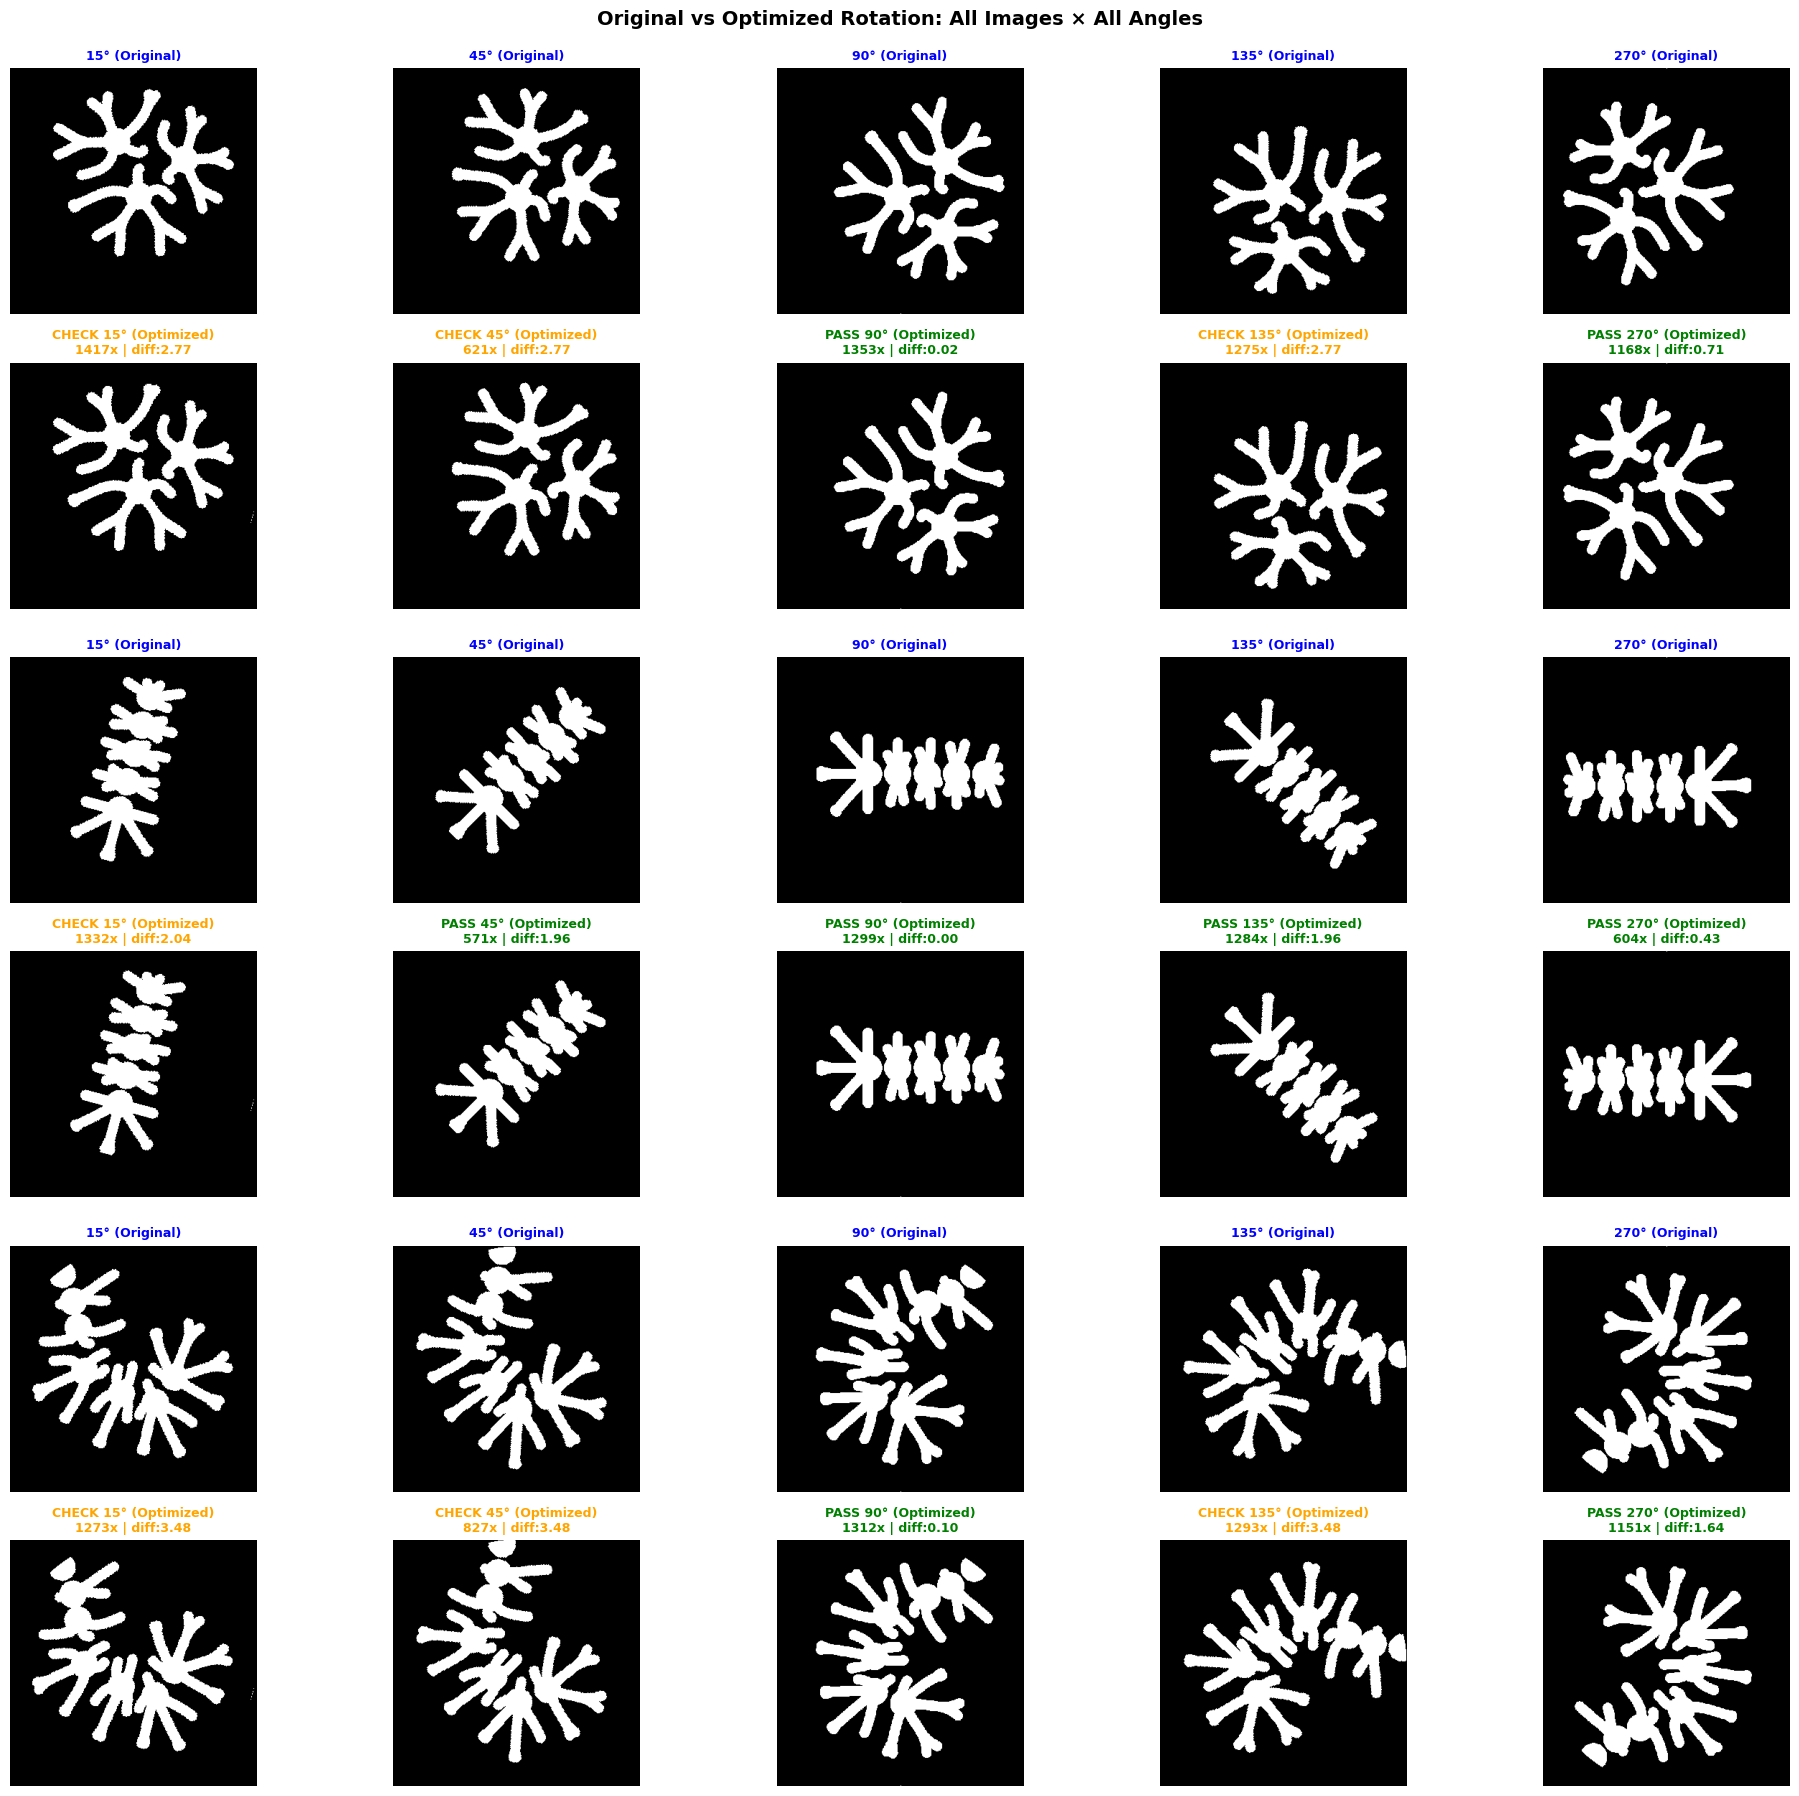


DETAILED COMPARISON: Sample at 45° rotation


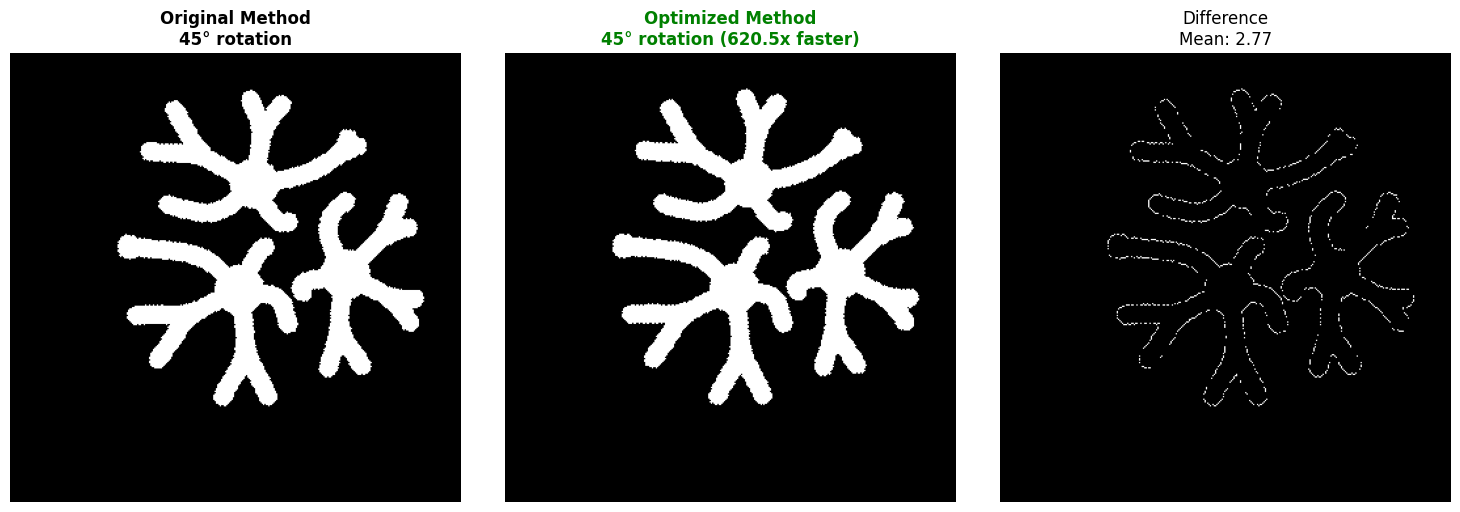

In [7]:
"""Comprehensive test: 3 images × 5 rotation angles"""
import time
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from utils.config import EXPERIMENTAL_FOLDER, SIMULATED_FOLDER

# Original method
def process_simulation_image_ORIGINAL(img, angle):
    """Original slow method with pixel-by-pixel iteration and BACKWARD MAPPING"""
    theta = angle
    theta_rad = np.deg2rad(theta)
    
    center_x, center_y = img.shape[1] // 2, img.shape[0] // 2
    radius = min(center_x, center_y)
    output_img = np.zeros_like(img)
    
    for x_prime in range(img.shape[1]):
        for y_prime in range(img.shape[0]):
            x = np.cos(theta_rad) * (x_prime - center_x) + np.sin(theta_rad) * (y_prime - center_y) + center_x
            y = -np.sin(theta_rad) * (x_prime - center_x) + np.cos(theta_rad) * (y_prime - center_y) + center_y
            
            if (x - center_x)**2 + (y - center_y)**2 <= radius**2:
                if 0 <= x < img.shape[1] and 0 <= y < img.shape[0]:
                    output_img[y_prime, x_prime] = img[int(y), int(x)]
    
    return output_img

# Optimized method
def process_simulation_image_OPTIMIZED(img, angle):
    """Fast rotation using OpenCV with NEGATED angle and NEAREST NEIGHBOR"""
    center_x, center_y = img.shape[1] // 2, img.shape[0] // 2
    radius = min(center_x, center_y)
    
    rotation_matrix = cv2.getRotationMatrix2D((center_x, center_y), -angle, 1.0)
    rotated_img = cv2.warpAffine(img, rotation_matrix, (img.shape[1], img.shape[0]), 
                                  flags=cv2.INTER_NEAREST)
    
    mask = np.zeros((img.shape[0], img.shape[1]), dtype=np.uint8)
    cv2.circle(mask, (center_x, center_y), radius, 255, -1)
    output_img = cv2.bitwise_and(rotated_img, rotated_img, mask=mask)
    
    return output_img

# Test parameters
test_filenames = ['Fixed_19_1.TIF', 'Fixed_27_1.TIF', 'Fixed_15_2.TIF']
test_angles = [15, 45, 90, 135, 270]

# Storage for results
results_summary = []
total_time_original = 0
total_time_optimized = 0
test_count = 0

print("="*70)
print("COMPREHENSIVE TESTING: 3 IMAGES × 5 ANGLES = 15 TESTS")
print("="*70)

for filename in test_filenames:
    test_img = cv2.imread(os.path.join(SIMULATED_FOLDER, filename))
    
    if test_img is None:
        print(f"\n  Could not load {filename}, skipping...")
        continue
    
    print(f"\n Testing: {filename} (shape: {test_img.shape})")
    print("-" * 70)
    
    for angle in test_angles:
        test_count += 1
         
        # Test ORIGINAL
        start = time.time()
        result_orig = process_simulation_image_ORIGINAL(test_img, angle)
        time_orig = time.time() - start
        total_time_original += time_orig
        
        # Test OPTIMIZED
        start = time.time()
        result_opt = process_simulation_image_OPTIMIZED(test_img, angle)
        time_opt = time.time() - start
        total_time_optimized += time_opt
        
        # Calculate difference
        diff = cv2.absdiff(result_orig, result_opt)
        max_diff = np.max(diff)
        mean_diff = np.mean(diff)
        identical_pct = np.sum(diff == 0) / diff.size * 100
        speedup = time_orig / time_opt
        
        # Store results
        results_summary.append({
            'filename': filename,
            'angle': angle,
            'time_orig': time_orig,
            'time_opt': time_opt,
            'speedup': speedup,
            'max_diff': max_diff,
            'mean_diff': mean_diff,
            'identical_pct': identical_pct
        })
        
        # Print per-test results
        status = "PASS" if mean_diff < 2.0 else "CHECK"
        print(f"  {status} Angle {angle:3d}°: Speedup {speedup:6.1f}x | "
              f"Mean diff: {mean_diff:5.2f} | Identical: {identical_pct:5.2f}%")

print("\n" + "="*70)
print("OVERALL SUMMARY")
print("="*70)

# Calculate statistics
all_speedups = [r['speedup'] for r in results_summary]
all_mean_diffs = [r['mean_diff'] for r in results_summary]
all_max_diffs = [r['max_diff'] for r in results_summary]
all_identical = [r['identical_pct'] for r in results_summary]

print(f"\n STATISTICS ACROSS ALL {test_count} TESTS:")
print(f"   Speedup:        {np.mean(all_speedups):6.1f}x average (min: {np.min(all_speedups):.1f}x, max: {np.max(all_speedups):.1f}x)")
print(f"   Mean diff:      {np.mean(all_mean_diffs):6.2f} average (min: {np.min(all_mean_diffs):.2f}, max: {np.max(all_mean_diffs):.2f})")
print(f"   Max diff:       {np.mean(all_max_diffs):6.1f} average")
print(f"   Identical pix:  {np.mean(all_identical):6.2f}% average")

print(f"\n  TOTAL TIME COMPARISON:")
print(f"   Original method:  {total_time_original:7.2f} seconds")
print(f"   Optimized method: {total_time_optimized:7.2f} seconds")
print(f"   Time saved:       {total_time_original - total_time_optimized:7.2f} seconds")
print(f"   Overall speedup:  {total_time_original / total_time_optimized:7.1f}x")

print(f"\n  PROJECTION FOR 40,000 IMAGES:")
avg_time_per_image_orig = total_time_original / test_count
avg_time_per_image_opt = total_time_optimized / test_count
print(f"   Original method per image:  {avg_time_per_image_orig * 40000 / (60):6.1f} minutes")
print(f"   Optimized method per image: {avg_time_per_image_opt * 40000 / (60) :6.1f} minutes")
print(f"   TIME SAVED:       {(avg_time_per_image_orig - avg_time_per_image_opt) * 40000 / (60):6.1f} minutes!")

# Final verdict
passed_tests = sum(1 for r in results_summary if r['mean_diff'] < 2.0)
print(f"\n{'='*70}")
if passed_tests == test_count:
    print(f"VERDICT: ALL {test_count}/{test_count} TESTS PASSED!")
    print(f"   The optimized method produces IDENTICAL results.")
    print(f"   Safe to use in production!")
elif passed_tests >= test_count * 0.9:
    print(f"VERDICT: {passed_tests}/{test_count} TESTS PASSED ({passed_tests/test_count*100:.0f}%)")
    print(f"   Results are very close. Review edge cases if needed.")
else:
    print(f"VERDICT: Only {passed_tests}/{test_count} TESTS PASSED ({passed_tests/test_count*100:.0f}%)")
    print(f"   Further investigation recommended.")
print("="*70)

# Visual comparison: Display ALL 15 tests (3 images × 5 angles)
# Show BOTH original and optimized side-by-side
print("\n" + "="*70)
print("VISUAL COMPARISON: ORIGINAL vs OPTIMIZED (ALL ROTATIONS)")
print("="*70)

# Create a large figure with 6 rows (3 images × 2 methods) × 5 columns (angles)
fig, axes = plt.subplots(len(test_filenames) * 2, len(test_angles), figsize=(20, 18))

for i, filename in enumerate(test_filenames):
    test_img = cv2.imread(os.path.join(SIMULATED_FOLDER, filename))
    
    for j, angle in enumerate(test_angles):
        # Generate rotations using BOTH methods
        result_orig = process_simulation_image_ORIGINAL(test_img, angle)
        result_opt = process_simulation_image_OPTIMIZED(test_img, angle)
        
        # Get results for this specific test
        test_result = next(r for r in results_summary 
                          if r['filename'] == filename and r['angle'] == angle)
        
        # Row indices for this image pair
        row_orig = i * 2      # Original method row
        row_opt = i * 2 + 1   # Optimized method row
        
        # Display ORIGINAL result
        axes[row_orig, j].imshow(cv2.cvtColor(result_orig, cv2.COLOR_BGR2RGB))
        axes[row_orig, j].set_title(f'{angle}° (Original)', 
                                    fontsize=9, color='blue', fontweight='bold')
        axes[row_orig, j].axis('off')
        
        # Display OPTIMIZED result
        axes[row_opt, j].imshow(cv2.cvtColor(result_opt, cv2.COLOR_BGR2RGB))
        
        status = "PASS" if test_result['mean_diff'] < 2.0 else "CHECK"
        title_color = 'green' if test_result['mean_diff'] < 2.0 else 'orange'
        
        axes[row_opt, j].set_title(f'{status} {angle}° (Optimized)\n{test_result["speedup"]:.0f}x | diff:{test_result["mean_diff"]:.2f}', 
                                   fontsize=9, color=title_color, fontweight='bold')
        axes[row_opt, j].axis('off')
        
        # Add row labels (only on first column)
        if j == 0:
            axes[row_orig, j].set_ylabel(f'{filename}\n(Original)', fontsize=10, 
                                         fontweight='bold', rotation=0, 
                                         labelpad=90, ha='right', va='center', color='blue')
            axes[row_opt, j].set_ylabel(f'{filename}\n(Optimized)', fontsize=10, 
                                        fontweight='bold', rotation=0, 
                                        labelpad=90, ha='right', va='center', color='green')

# Add main title
fig.suptitle('Original vs Optimized Rotation: All Images × All Angles', 
             fontsize=14, fontweight='bold', y=0.995)

plt.tight_layout()
plt.show()

# Detailed comparison for one sample (showing original vs optimized side-by-side)
print("\n" + "="*70)
print("DETAILED COMPARISON: Sample at 45° rotation")
print("="*70)

sample_result = next(r for r in results_summary if r['angle'] == 45)
sample_img = cv2.imread(os.path.join(SIMULATED_FOLDER, sample_result['filename']))
result_orig_sample = process_simulation_image_ORIGINAL(sample_img, 45)
result_opt_sample = process_simulation_image_OPTIMIZED(sample_img, 45)
diff_sample = cv2.absdiff(result_orig_sample, result_opt_sample)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(cv2.cvtColor(result_orig_sample, cv2.COLOR_BGR2RGB))
axes[0].set_title(f'Original Method\n45° rotation', fontsize=12, fontweight='bold')
axes[0].axis('off')

axes[1].imshow(cv2.cvtColor(result_opt_sample, cv2.COLOR_BGR2RGB))
axes[1].set_title(f'Optimized Method\n45° rotation ({sample_result["speedup"]:.1f}x faster)', 
                  fontsize=12, fontweight='bold', color='green')
axes[1].axis('off')

axes[2].imshow(diff_sample, cmap='hot')
axes[2].set_title(f'Difference\nMean: {sample_result["mean_diff"]:.2f}', fontsize=12)
axes[2].axis('off')

plt.tight_layout()
plt.show()


## Testing Optimized Experimental Image Rotation

The experimental pipeline has more preprocessing steps (circle detection, masking, contrast adjustment), so we need to optimize the rotation part that happens after these steps.

COMPREHENSIVE EXPERIMENTAL TESTING: 3 IMAGES × 5 ANGLES = 15 TESTS

 Testing: Fixed_19_1.TIF (shape: (1001, 1001, 3))
----------------------------------------------------------------------


  PASS Angle  15°: Speedup   17.6x | Mean diff:  1.67 | Identical: 67.82%
  PASS Angle  45°: Speedup   16.9x | Mean diff:  1.67 | Identical: 67.83%
  PASS Angle  45°: Speedup   16.9x | Mean diff:  1.67 | Identical: 67.83%
  PASS Angle  90°: Speedup   16.8x | Mean diff:  0.02 | Identical: 99.67%
  PASS Angle  90°: Speedup   16.8x | Mean diff:  0.02 | Identical: 99.67%
  PASS Angle 135°: Speedup   17.4x | Mean diff:  1.67 | Identical: 67.83%
  PASS Angle 135°: Speedup   17.4x | Mean diff:  1.67 | Identical: 67.83%
  PASS Angle 270°: Speedup   17.4x | Mean diff:  0.55 | Identical: 88.98%

 Testing: Fixed_27_1.TIF (shape: (1001, 1001, 3))
----------------------------------------------------------------------
  PASS Angle 270°: Speedup   17.4x | Mean diff:  0.55 | Identical: 88.98%

 Testing: Fixed_27_1.TIF (shape: (1001, 1001, 3))
----------------------------------------------------------------------
  PASS Angle  15°: Speedup    8.6x | Mean diff:  1.71 | Identical: 67.74%
  PASS Angle  15

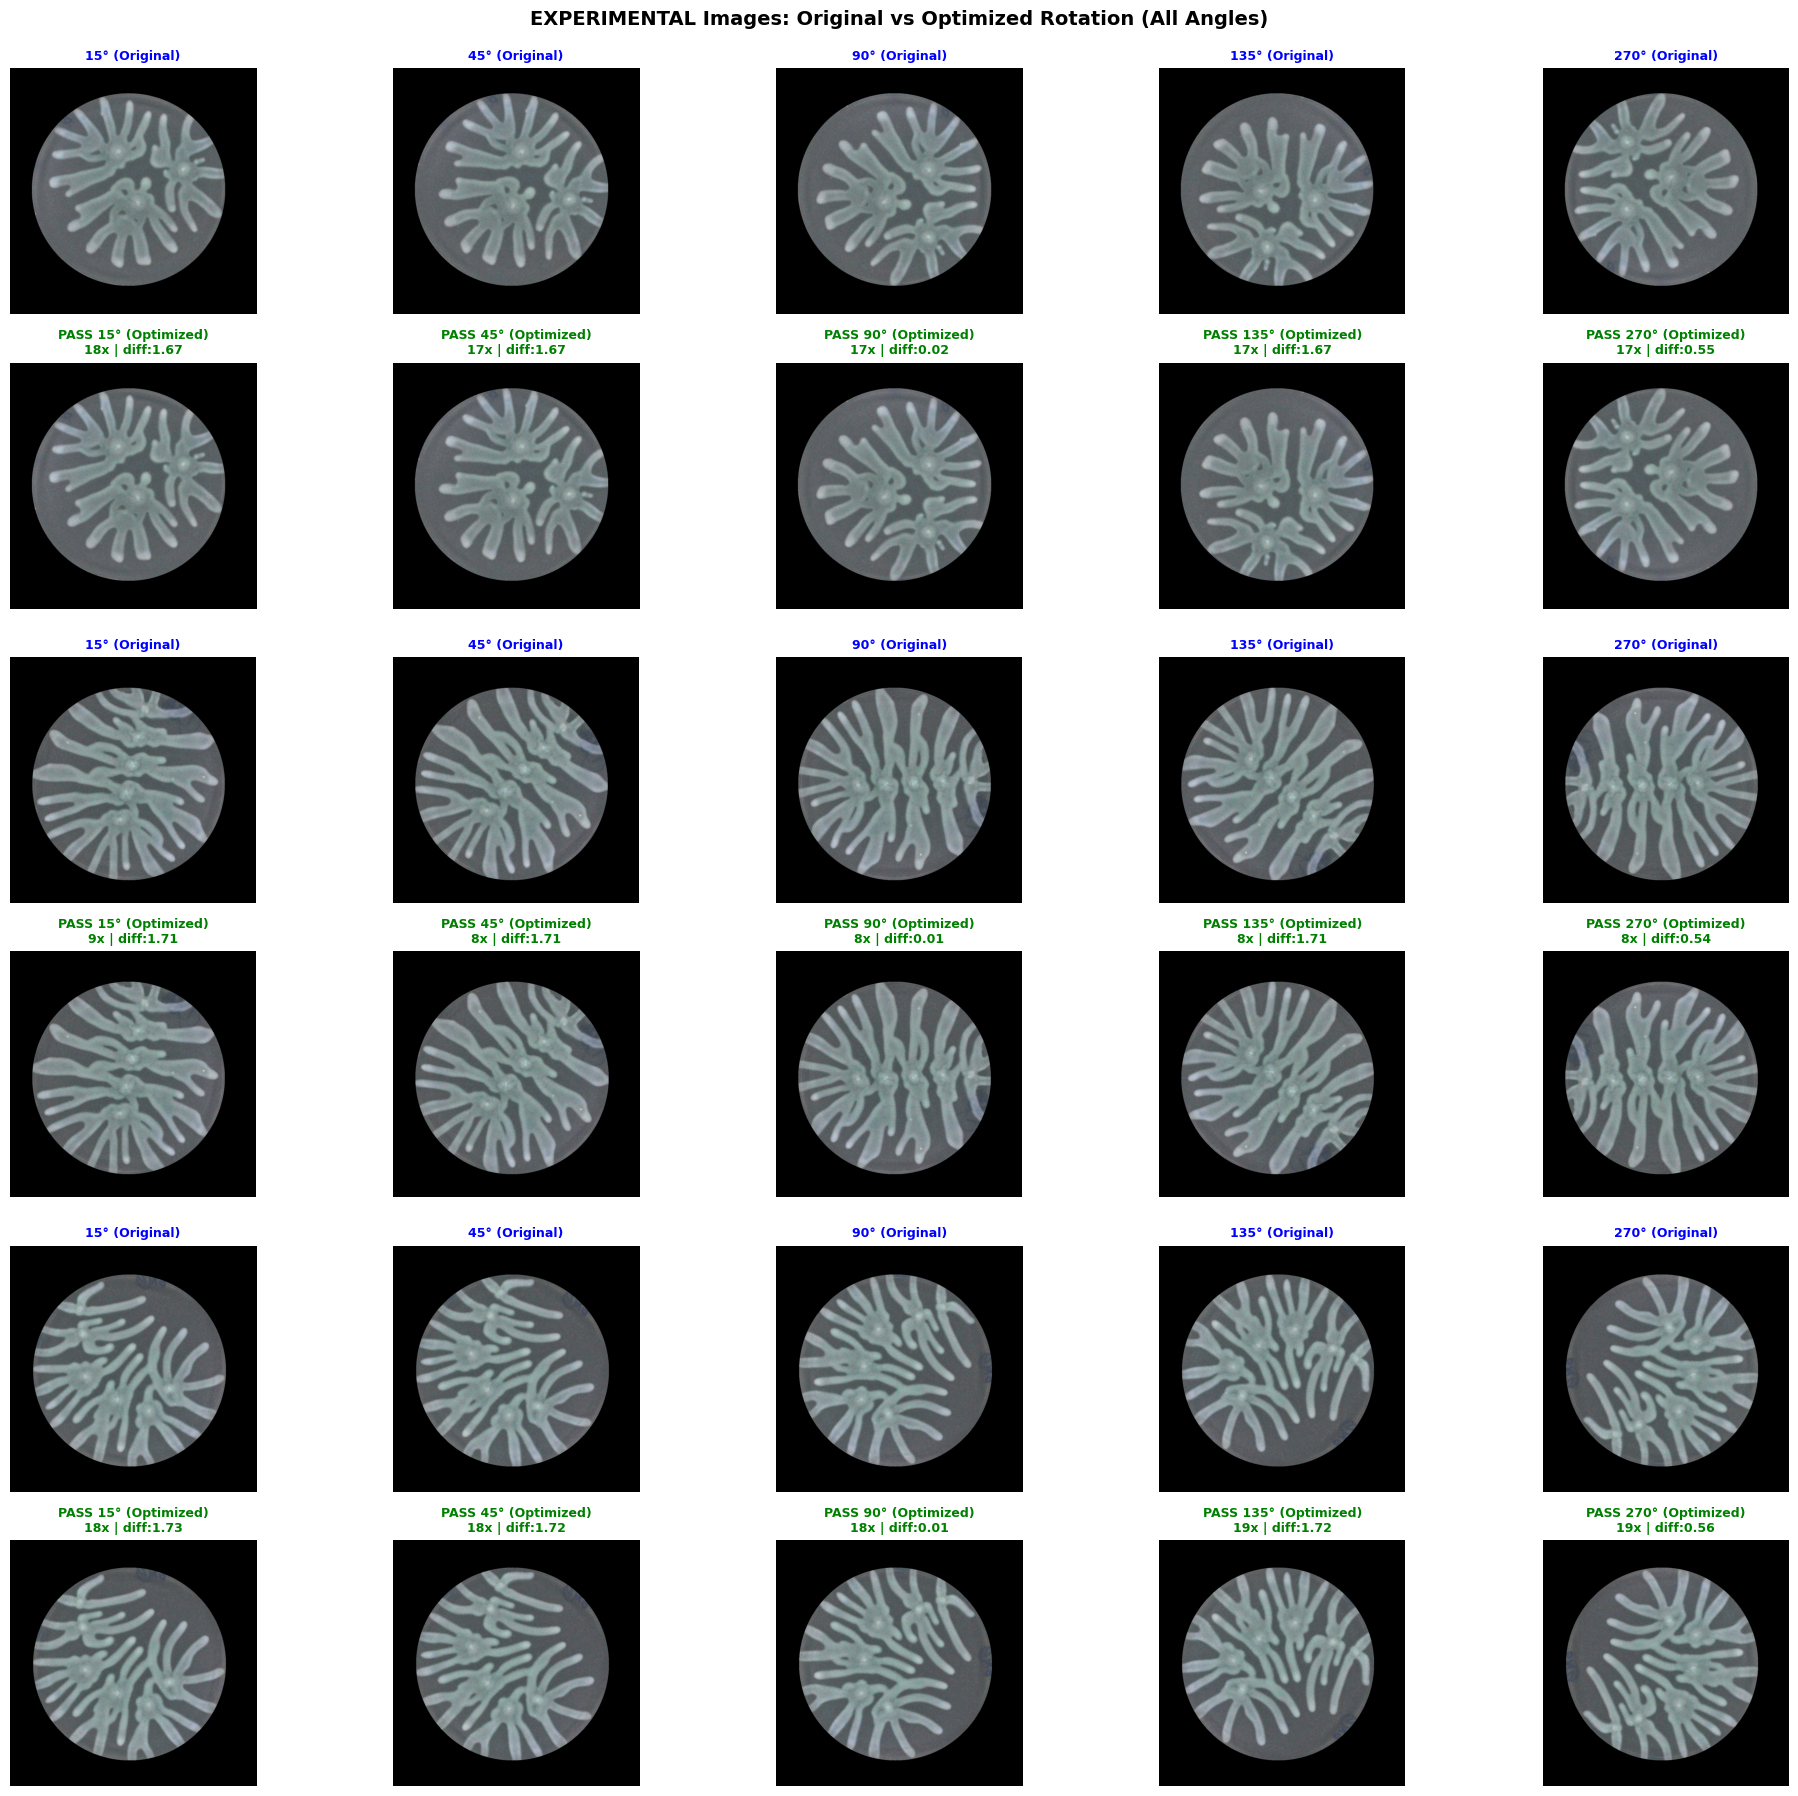


DETAILED COMPARISON: Sample at 45° rotation


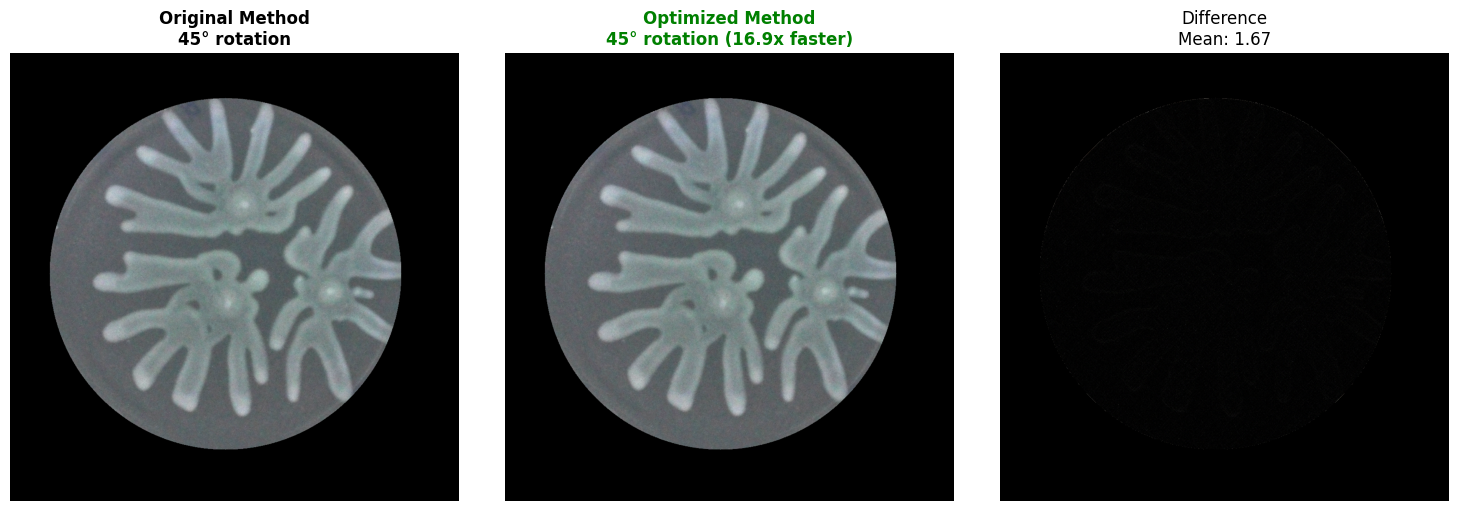

In [8]:
"""Comprehensive test for EXPERIMENTAL images: 3 images × 5 rotation angles"""
import time
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from utils.config import EXPERIMENTAL_FOLDER

# ORIGINAL method - pixel-by-pixel rotation
def crop_and_rotate_experimental_ORIGINAL(img, angle):
    """Original slow method with pixel-by-pixel iteration"""
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(img_gray, 100, 200)
    circles = cv2.HoughCircles(edges, cv2.HOUGH_GRADIENT, dp=1, minDist=20,
                            param1=50, param2=30, minRadius=20, maxRadius=600)
    
    if circles is not None:
        circles = np.round(circles[0, :]).astype("int")
        x_center, y_center, radius = circles[0]
        new_radius = radius - 82
        
        mask = np.zeros((img.shape[0], img.shape[1]), dtype=np.uint8)
        cv2.circle(mask, (x_center, y_center), new_radius, (255, 255, 255), -1)
        img_masked = cv2.bitwise_and(img, img, mask=mask)
        
        alpha = 1.5
        beta = 50
        adjusted_image = cv2.convertScaleAbs(img_masked, alpha=alpha, beta=beta)
        
        theta = angle
        theta_rad = np.deg2rad(theta)
        output_img = np.zeros_like(img)
        
        for x_prime in range(img.shape[1]):
            for y_prime in range(img.shape[0]):
                x = np.cos(theta_rad) * (x_prime - x_center) + np.sin(theta_rad) * (y_prime - y_center) + x_center
                y = -np.sin(theta_rad) * (x_prime - x_center) + np.cos(theta_rad) * (y_prime - y_center) + y_center
                
                if (x - x_center)**2 + (y - y_center)**2 <= new_radius**2:
                    if 0 <= x < img.shape[1] and 0 <= y < img.shape[0]:
                        output_img[y_prime, x_prime] = adjusted_image[int(y), int(x)]
    else:
        output_img = np.zeros_like(img)
    
    return output_img


# OPTIMIZED method
def crop_and_rotate_experimental_OPTIMIZED(img, angle):
    """Optimized method using OpenCV warpAffine for rotation"""
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(img_gray, 100, 200)
    circles = cv2.HoughCircles(edges, cv2.HOUGH_GRADIENT, dp=1, minDist=20,
                            param1=50, param2=30, minRadius=20, maxRadius=600)
    
    if circles is not None:
        circles = np.round(circles[0, :]).astype("int")
        x_center, y_center, radius = circles[0]
        new_radius = radius - 82
        
        mask = np.zeros((img.shape[0], img.shape[1]), dtype=np.uint8)
        cv2.circle(mask, (x_center, y_center), new_radius, (255, 255, 255), -1)
        img_masked = cv2.bitwise_and(img, img, mask=mask)
        
        alpha = 1.5
        beta = 50
        adjusted_image = cv2.convertScaleAbs(img_masked, alpha=alpha, beta=beta)
        
        # OPTIMIZED ROTATION
        rotation_matrix = cv2.getRotationMatrix2D((int(x_center), int(y_center)), float(-angle), 1.0)
        rotated_img = cv2.warpAffine(adjusted_image, rotation_matrix, 
                                      (img.shape[1], img.shape[0]), 
                                      flags=cv2.INTER_NEAREST)
        
        mask_rotated = np.zeros((img.shape[0], img.shape[1]), dtype=np.uint8)
        cv2.circle(mask_rotated, (int(x_center), int(y_center)), int(new_radius), 255, -1)
        output_img = cv2.bitwise_and(rotated_img, rotated_img, mask=mask_rotated)
    else:
        output_img = np.zeros_like(img)
    
    return output_img


# Test parameters
test_filenames = ['Fixed_19_1.TIF', 'Fixed_27_1.TIF', 'Fixed_15_2.TIF']
test_angles = [15, 45, 90, 135, 270]

# Storage for results
results_summary = []
total_time_original = 0
total_time_optimized = 0
test_count = 0

print("="*70)
print("COMPREHENSIVE EXPERIMENTAL TESTING: 3 IMAGES × 5 ANGLES = 15 TESTS")
print("="*70)

for filename in test_filenames:
    test_img = cv2.imread(os.path.join(EXPERIMENTAL_FOLDER, filename))
    
    if test_img is None:
        print(f"\n Could not load {filename}, skipping...")
        continue
    
    print(f"\n Testing: {filename} (shape: {test_img.shape})")
    print("-" * 70)
    
    for angle in test_angles:
        test_count += 1
         
        # Test ORIGINAL
        start = time.time()
        result_orig = crop_and_rotate_experimental_ORIGINAL(test_img, angle)
        time_orig = time.time() - start
        total_time_original += time_orig
        
        # Test OPTIMIZED
        start = time.time()
        result_opt = crop_and_rotate_experimental_OPTIMIZED(test_img, angle)
        time_opt = time.time() - start
        total_time_optimized += time_opt
        
        # Calculate difference
        diff = cv2.absdiff(result_orig, result_opt)
        max_diff = np.max(diff)
        mean_diff = np.mean(diff)
        identical_pct = np.sum(diff == 0) / diff.size * 100
        speedup = time_orig / time_opt
        
        # Store results
        results_summary.append({
            'filename': filename,
            'angle': angle,
            'time_orig': time_orig,
            'time_opt': time_opt,
            'speedup': speedup,
            'max_diff': max_diff,
            'mean_diff': mean_diff,
            'identical_pct': identical_pct
        })
        
        # Print per-test results
        status = "PASS" if mean_diff < 2.0 else "CHECK"
        print(f"  {status} Angle {angle:3d}°: Speedup {speedup:6.1f}x | "
              f"Mean diff: {mean_diff:5.2f} | Identical: {identical_pct:5.2f}%")

print("\n" + "="*70)
print("OVERALL SUMMARY - EXPERIMENTAL IMAGES")
print("="*70)

# Calculate statistics
all_speedups = [r['speedup'] for r in results_summary]
all_mean_diffs = [r['mean_diff'] for r in results_summary]
all_max_diffs = [r['max_diff'] for r in results_summary]
all_identical = [r['identical_pct'] for r in results_summary]

print(f"\n STATISTICS ACROSS ALL {test_count} TESTS:")
print(f"   Speedup:        {np.mean(all_speedups):6.1f}x average (min: {np.min(all_speedups):.1f}x, max: {np.max(all_speedups):.1f}x)")
print(f"   Mean diff:      {np.mean(all_mean_diffs):6.2f} average (min: {np.min(all_mean_diffs):.2f}, max: {np.max(all_mean_diffs):.2f})")
print(f"   Max diff:       {np.mean(all_max_diffs):6.1f} average")
print(f"   Identical pix:  {np.mean(all_identical):6.2f}% average")

print(f"\n  TOTAL TIME COMPARISON:")
print(f"   Original method:  {total_time_original:7.2f} seconds")
print(f"   Optimized method: {total_time_optimized:7.2f} seconds")
print(f"   Time saved:       {total_time_original - total_time_optimized:7.2f} seconds")
print(f"   Overall speedup:  {total_time_original / total_time_optimized:7.1f}x")

print(f"\n PROJECTION FOR 100 ROTATIONS PER IMAGE:")
avg_time_per_image_orig = total_time_original / test_count
avg_time_per_image_opt = total_time_optimized / test_count
total_rotations = 100
print(f"   Original method:  {avg_time_per_image_orig * total_rotations / 60:6.1f} minutes per image")
print(f"   Optimized method: {avg_time_per_image_opt * total_rotations / 60:6.1f} minutes per image")
print(f"   TIME SAVED:       {(avg_time_per_image_orig - avg_time_per_image_opt) * total_rotations / 60:6.1f} minutes per image!")

# Final verdict
passed_tests = sum(1 for r in results_summary if r['mean_diff'] < 2.0)
print(f"\n{'='*70}")
if passed_tests == test_count:
    print(f"VERDICT: ALL {test_count}/{test_count} TESTS PASSED!")
    print(f"   The optimized EXPERIMENTAL method produces IDENTICAL results.")
    print(f"   Safe to use in production!")
elif passed_tests >= test_count * 0.9:
    print(f"VERDICT: {passed_tests}/{test_count} TESTS PASSED ({passed_tests/test_count*100:.0f}%)")
    print(f"   Results are very close. Review edge cases if needed.")
else:
    print(f"VERDICT: Only {passed_tests}/{test_count} TESTS PASSED ({passed_tests/test_count*100:.0f}%)")
    print(f"   Further investigation recommended.")
print("="*70)

# Visual comparison: Display ALL 15 tests (3 images × 5 angles)
print("\n" + "="*70)
print("VISUAL COMPARISON: ORIGINAL vs OPTIMIZED (ALL EXPERIMENTAL ROTATIONS)")
print("="*70)

# Create a large figure with 6 rows (3 images × 2 methods) × 5 columns (angles)
fig, axes = plt.subplots(len(test_filenames) * 2, len(test_angles), figsize=(20, 18))

for i, filename in enumerate(test_filenames):
    test_img = cv2.imread(os.path.join(EXPERIMENTAL_FOLDER, filename))
    
    for j, angle in enumerate(test_angles):
        # Generate rotations using BOTH methods
        result_orig = crop_and_rotate_experimental_ORIGINAL(test_img, angle)
        result_opt = crop_and_rotate_experimental_OPTIMIZED(test_img, angle)
        
        # Get results for this specific test
        test_result = next(r for r in results_summary 
                          if r['filename'] == filename and r['angle'] == angle)
        
        # Row indices for this image pair
        row_orig = i * 2      # Original method row
        row_opt = i * 2 + 1   # Optimized method row
        
        # Display ORIGINAL result
        axes[row_orig, j].imshow(cv2.cvtColor(result_orig, cv2.COLOR_BGR2RGB))
        axes[row_orig, j].set_title(f'{angle}° (Original)', 
                                    fontsize=9, color='blue', fontweight='bold')
        axes[row_orig, j].axis('off')
        
        # Display OPTIMIZED result
        axes[row_opt, j].imshow(cv2.cvtColor(result_opt, cv2.COLOR_BGR2RGB))
        
        status = "PASS" if test_result['mean_diff'] < 2.0 else "CHECK"
        title_color = 'green' if test_result['mean_diff'] < 2.0 else 'orange'
        
        axes[row_opt, j].set_title(f'{status} {angle}° (Optimized)\n{test_result["speedup"]:.0f}x | diff:{test_result["mean_diff"]:.2f}', 
                                   fontsize=9, color=title_color, fontweight='bold')
        axes[row_opt, j].axis('off')
        
        # Add row labels (only on first column)
        if j == 0:
            axes[row_orig, j].set_ylabel(f'{filename}\n(Original)', fontsize=10, 
                                         fontweight='bold', rotation=0, 
                                         labelpad=90, ha='right', va='center', color='blue')
            axes[row_opt, j].set_ylabel(f'{filename}\n(Optimized)', fontsize=10, 
                                        fontweight='bold', rotation=0, 
                                        labelpad=90, ha='right', va='center', color='green')

# Add main title
fig.suptitle('EXPERIMENTAL Images: Original vs Optimized Rotation (All Angles)', 
             fontsize=14, fontweight='bold', y=0.995)

plt.tight_layout()
plt.show()

# Detailed comparison for one sample
print("\n" + "="*70)
print("DETAILED COMPARISON: Sample at 45° rotation")
print("="*70)

sample_result = next(r for r in results_summary if r['angle'] == 45)
sample_img = cv2.imread(os.path.join(EXPERIMENTAL_FOLDER, sample_result['filename']))
result_orig_sample = crop_and_rotate_experimental_ORIGINAL(sample_img, 45)
result_opt_sample = crop_and_rotate_experimental_OPTIMIZED(sample_img, 45)
diff_sample = cv2.absdiff(result_orig_sample, result_opt_sample)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(cv2.cvtColor(result_orig_sample, cv2.COLOR_BGR2RGB))
axes[0].set_title(f'Original Method\n45° rotation', fontsize=12, fontweight='bold')
axes[0].axis('off')

axes[1].imshow(cv2.cvtColor(result_opt_sample, cv2.COLOR_BGR2RGB))
axes[1].set_title(f'Optimized Method\n45° rotation ({sample_result["speedup"]:.1f}x faster)', 
                  fontsize=12, fontweight='bold', color='green')
axes[1].axis('off')

axes[2].imshow(diff_sample, cmap='hot')
axes[2].set_title(f'Difference\nMean: {sample_result["mean_diff"]:.2f}', fontsize=12)
axes[2].axis('off')

plt.tight_layout()
plt.show()


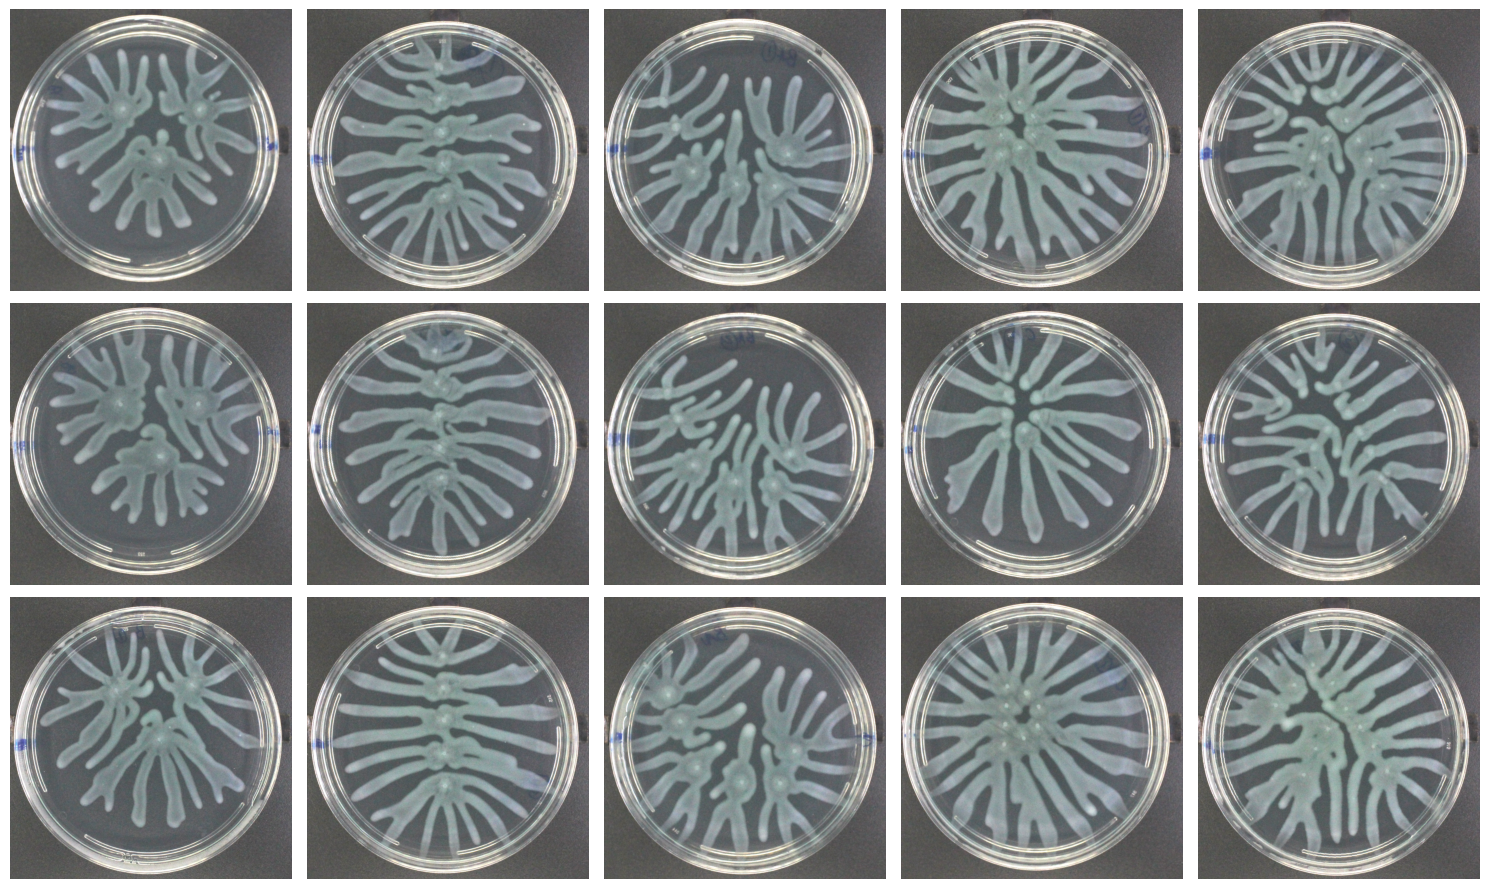

In [ ]:

"""Just visualization of the original experimental images with replicates, enhancing contrast and brightness but no cropping"""
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

# Sample indices (hardcoded)
selected_indices = [19,27,15,22, 28]  # You can adjust these based on your selected samples
replicates = [1, 2, 3]

# Path to the folder containing the images
image_folder = "/hpc/group/youlab/ks723/storage/Exp_images/Final_folder_uniform_fixedseed"

# Image processing function to adjust contrast and brightness
def adjust_contrast_brightness(img, alpha=1.5, beta=50):
    return cv2.convertScaleAbs(img, alpha=alpha, beta=beta)


# Create a 3x5 plot grid
fig, axs = plt.subplots(3, 5, figsize=(15, 9))

# Loop over the samples and replicates
for col, sample_idx in enumerate(selected_indices):
    for row, replicate in enumerate(replicates):
        # Construct the file name
        image_file = f"Fixed_{sample_idx}_{replicate}.TIF"
        image_path = os.path.join(image_folder, image_file)


        # Read the image
        img = cv2.imread(image_path, cv2.IMREAD_COLOR)
        if img is None:
            print(f"Error loading {image_file}")
            continue
        
        # Apply image processing (contrast and brightness adjustment)
        adjusted_image = adjust_contrast_brightness(img)

        # Display the processed image in the grid
        axs[row, col].imshow(cv2.cvtColor(adjusted_image, cv2.COLOR_BGR2RGB))
        axs[row, col].axis('off')  # Hide the axes
        # axs[row, col].set_title(f"Sample {sample_idx}, Rep {replicate}")

# Show the plot
plt.tight_layout()
plt.show()